In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shared drives/SI671_final_project/SI671_final_project/Data_file'

Mounted at /content/drive
/content/drive/Shared drives/SI671


In [ ]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import time
import pickle
from IPython.display import SVG

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

In [ ]:
from keras.layers import Input, Activation, Masking, TimeDistributed, LSTM, Conv1D, Embedding 
from keras.layers.core import Reshape, Dropout, Dense
from keras.layers.merge import Multiply, Dot, Concatenate
from keras.models import Sequential, Model, load_model, save_model
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot

In [ ]:
data = pd.read_json('Grocery_and_Gourmet_Food_5.json', lines=True)
meta_data = pd.read_json('meta_Grocery_and_Gourmet_Food.json', lines=True)

In [ ]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN
2,5,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,NaN,NaN,NaN
3,5,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,NaN,NaN,NaN
4,5,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,NaN,NaN,NaN


In [ ]:
data.shape

(1143860, 12)

In [ ]:
data = data[["asin", "summary", "reviewText", "overall", "reviewerID", 
             "reviewerName", "reviewTime"]]

data.rename(columns={"overall":"score", "reviewerID":"user_id",
                     "reviewerName":"user_name"},inplace=True)

In [ ]:
data.head()

,asin,summary,reviewText,score,user_id,user_name,reviewTime
0,4639725183,Five Stars,No adverse comment.,5,A1QVBUH9E1V6I8,Jamshed Mathur,"11 19, 2014"
1,4639725183,Great product.,Gift for college student.,5,A3GEOILWLK86XM,itsjustme,"10 13, 2016"
2,4639725183,Strong,"If you like strong tea, this is for you. It mi...",5,A32RD6L701BIGP,Krystal Clifton,"11 21, 2015"
3,4639725183,Great tea,Love the tea. The flavor is way better than th...,5,A2UY1O1FBGKIE6,U. Kane,"08 12, 2015"
4,4639725183,This is the tea I remembered!,I have searched everywhere until I browsed Ama...,5,A3QHVBQYDV7Z6U,The Nana,"05 28, 2015"


In [ ]:
# Get percentage of missing values for each column
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
reviewText,reviewText,0.034095
summary,summary,0.019146
user_name,user_name,0.012064
asin,asin,0.000000
score,score,0.000000
user_id,user_id,0.000000
reviewTime,reviewTime,0.000000


In [ ]:
# drop rows that have missing values on reviewtext and summary
data = data.dropna(subset=['reviewText', 'summary',"user_name"])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


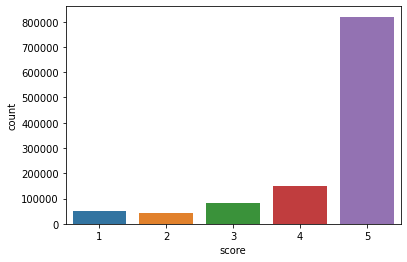

In [ ]:
# Get the distribution of overall grades
sbn.countplot(data["score"])
plt.show()

In [ ]:
data["score"].describe()

count    1.143155e+06
mean     4.442064e+00
std      1.063969e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: score, dtype: float64

The median in both datasets is 5. This means that the data is skewed towards high ratings. This is a common bias in internet ratings, where people tend to rate items that they liked, and rarely spend time to comment something they dislike or are indiferent to. This will have a huge impact on the way I model the recommendation problem.

**Key conclusions from above:**

Reviews are skewed towards positive

Many people agree with score 5 reviews

### Arrange and clean the data

Cleaning, handling missing data, normalization, etc:

For the algorithm in keras to work, remap all item_ids and user_ids to an interger between 0 and the total number of users or the total number of items


In [ ]:
# unique item
items = data.asin.unique()
item_map = {i:val for i,val in enumerate(items)}
inverse_item_map = {val:i for i,val in enumerate(items)}
data["old_item_id"] = data["asin"]
data["item_id"] = data["asin"].map(inverse_item_map)

In [ ]:
print("unique items: ", len(items))

unique items:  41320


In [ ]:
# unique user
users = data.user_id.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
data["old_user_id"] = data["user_id"]
data["user_id"] = data["user_id"].map(inverse_user_map)

In [ ]:
print("unique users: ", len(users))

unique users:  127475


In [ ]:
data.head(3)

,asin,summary,reviewText,score,user_id,user_name,reviewTime,old_item_id,item_id,old_user_id
0,4639725183,Five Stars,No adverse comment.,5,0,Jamshed Mathur,"11 19, 2014",4639725183,0,A1QVBUH9E1V6I8
1,4639725183,Great product.,Gift for college student.,5,1,itsjustme,"10 13, 2016",4639725183,0,A3GEOILWLK86XM
2,4639725183,Strong,"If you like strong tea, this is for you. It mi...",5,2,Krystal Clifton,"11 21, 2015",4639725183,0,A32RD6L701BIGP


**Check the distribution of number of ratings per user**

In [ ]:
user_ratings = data["old_user_id"].value_counts().reset_index()
user_ratings.columns = ["old_user_id", "num_ratings"]
user_ratings["num_ratings"].describe()

count    127475.000000
mean          8.967680
std           8.681537
min           1.000000
25%           5.000000
50%           7.000000
75%           9.000000
max         572.000000
Name: num_ratings, dtype: float64

The distribution of number of ratings per user is very skewed in both datasets, with 50% of people having done a small number of reviews, and few made many ratings. I will check if it gives us enough information for generating good recommendations.



### Check the Distribution of the number of ratings per item

In [ ]:
data.columns

Index(['asin', 'summary', 'reviewText', 'score', 'user_id', 'user_name',
       'reviewTime', 'old_item_id', 'item_id', 'old_user_id'],
      dtype='object')

In [ ]:
items_avg = data[["old_item_id","score"]]
items_avg = items_avg.groupby("old_item_id").agg(["count","mean"]).reset_index()
items_avg.columns = ["old_item_id","num_ratings","avg_rating"]
items_avg.head()

,old_item_id,num_ratings,avg_rating
0,4639725043,30,4.200000
1,4639725183,12,4.833333
2,5463213682,9,4.888889
3,9742356831,96,4.552083
4,B00004S1C5,14,4.000000


In [ ]:
items_avg["num_ratings"].describe()

count    41320.000000
mean        27.665900
std         95.863889
min          1.000000
25%          6.000000
50%         10.000000
75%         22.000000
max       7383.000000
Name: num_ratings, dtype: float64

Again, the distribution of number of ratings per item is very skewed in both datasets, with 50% of the items having a small number of ratings whereas few got many ratings. I will check if the distribution of items rating is good enough to generate good recommendations.

### Explore metadata

In [ ]:
meta_data.head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,details
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...",,"[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],[],,Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,,,$41.91,0681727810,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...",,"[Shipped from UK, please allow 10 to 21 busine...",,Trim Healthy Mama Xylitol,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,,,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,,,,0853347867,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",,[Jazz up your cakes with a sparkling monogram ...,,Letter C - Swarovski Crystal Monogram Wedding ...,[],[],,Unik Occasions,[],"[>#669,941 in Kitchen & Dining (See Top 100 in...",[B07DXN65TF],Amazon Home,,"September 21, 2010",$29.95,1888861118,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",,"[Large Letter - Height 4.75""]",,Letter H - Swarovski Crystal Monogram Wedding ...,[],[],,Other,"[Large Letter - Height 4.75""]","[>#832,581 in Kitchen & Dining (See Top 100 in...",[],Amazon Home,,"September 11, 2011",$11.45,1888861517,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",,"[4.75""]",,Letter S - Swarovski Crystal Monogram Wedding ...,[],[],,Unik Occasions,"[4.75"" height]","[>#590,999 in Kitchen & Dining (See Top 100 in...",[],Amazon Home,,"September 11, 2011",$15.00,1888861614,NaN


In [ ]:
meta_data.shape

(287051, 18)

In [ ]:
meta_data.columns

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'image',
       'tech2', 'brand', 'feature', 'rank', 'also_view', 'main_cat',
       'similar_item', 'date', 'price', 'asin', 'details'],
      dtype='object')

In [ ]:
meta_a = meta_data[["asin","title","price"]]
meta_a["price"] = meta_a["price"].apply(lambda x: x[1:] if len(x)>0 
                                        and len(x) < 8 else 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
meta_a.head()

,asin,title,price
0,0681727810,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,41.91
1,0853347867,Trim Healthy Mama Xylitol,0
2,1888861118,Letter C - Swarovski Crystal Monogram Wedding ...,29.95
3,1888861517,Letter H - Swarovski Crystal Monogram Wedding ...,11.45
4,1888861614,Letter S - Swarovski Crystal Monogram Wedding ...,15.00


In [ ]:
meta_a[meta_a["price"]==0].shape[0]/meta_a.shape[0]

0.5400643091297366

More than half of price are missing, so we are not going to use this feature.

In [ ]:
meta_a = meta_a[["asin","title"]]

In [ ]:
meta_a.head()

,asin,title
0,0681727810,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs
1,0853347867,Trim Healthy Mama Xylitol
2,1888861118,Letter C - Swarovski Crystal Monogram Wedding ...
3,1888861517,Letter H - Swarovski Crystal Monogram Wedding ...
4,1888861614,Letter S - Swarovski Crystal Monogram Wedding ...


In [ ]:
data.shape

(1143155, 10)

In [ ]:
meta = meta_a.groupby("asin")["title"].apply(list)
meta = pd.DataFrame(meta)
meta["title"] = meta.title.apply(lambda x: x[0])

In [ ]:
# combine meta data with our data
data_a =  pd.merge(data,meta,how='left',on="asin")

In [ ]:
data_a.shape

(1143155, 11)

### Explicit Feedback Recommender System

Framed the recommendation system as a rating prediction machine learning problem: Predict an item's ratings in order to be able to recommend to a user an item that he is likely to rate high if he buys it.

In [ ]:
# Randomly separate the data into a training and test set.
data_train, data_test = train_test_split(data_a, test_size=0.2, random_state=0) 

In [ ]:
data_train.shape

(914524, 11)

In [ ]:
data_test.shape

(228631, 11)

In [ ]:
data_a.head()

,asin,summary,reviewText,score,user_id,user_name,reviewTime,old_item_id,item_id,old_user_id,title
0,4639725183,Five Stars,No adverse comment.,5,0,Jamshed Mathur,"11 19, 2014",4639725183,0,A1QVBUH9E1V6I8,Lipton Yellow Label Finest Blend Tea Bags 100 ...
1,4639725183,Great product.,Gift for college student.,5,1,itsjustme,"10 13, 2016",4639725183,0,A3GEOILWLK86XM,Lipton Yellow Label Finest Blend Tea Bags 100 ...
2,4639725183,Strong,"If you like strong tea, this is for you. It mi...",5,2,Krystal Clifton,"11 21, 2015",4639725183,0,A32RD6L701BIGP,Lipton Yellow Label Finest Blend Tea Bags 100 ...
3,4639725183,Great tea,Love the tea. The flavor is way better than th...,5,3,U. Kane,"08 12, 2015",4639725183,0,A2UY1O1FBGKIE6,Lipton Yellow Label Finest Blend Tea Bags 100 ...
4,4639725183,This is the tea I remembered!,I have searched everywhere until I browsed Ama...,5,4,The Nana,"05 28, 2015",4639725183,0,A3QHVBQYDV7Z6U,Lipton Yellow Label Finest Blend Tea Bags 100 ...


**Create an architecture that mixes the collaborative and content based filtering approaches**

Collaborative Part: Predict items ratings to recommend to the user items which he is likely to rate high according to learnt item & user embeddings (learn similarity from interactions).

Content based part: Use metadata inputs (such as price and title) about items to recommend to the user contents similar to those he rated high (learn similarity of item attributes)

In [ ]:
# create title mappings
titles = data_a["title"].unique()
titles_map = {i:val for i,val in enumerate(titles)}
inverse_titles_map = {val:i for i,val in enumerate(titles)}
print("number of unique titles: ", len(titles))

data_a["title_id"] = data_a["title"].map(inverse_titles_map)
item2titles = {}
for val in data_a[["item_id","title_id"]].dropna().drop_duplicates().iterrows():
  # print(val[1])
  item2titles[val[1]["item_id"]] = val[1]["title_id"] 

number of unique titles:  40970


In [ ]:
# add title_id to train and test dataset
data_train["title_id"] = data_a["item_id"].map(item2titles)
data_test["title_id"] = data_a["item_id"].map(item2titles)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data_train.head()

,asin,summary,reviewText,score,user_id,user_name,reviewTime,old_item_id,item_id,old_user_id,title,title_id
943860,B00ZAQ33I0,Four Stars,Works well in homemade ice-cream,4,31388,Kindle Customer,"04 14, 2017",B00ZAQ33I0,34232,AV0ABVI0M9O2H,"Natural Vanilla Bean Powder, Raw Ground Vanill...",33935
543559,B005TBURAI,Latin A1 sauce,"I saw this listed as a recipe ingredient, went...",2,47419,Lv2Read,"01 19, 2016",B005TBURAI,16618,A2CVUD1KWW2TUT,"Lizano Salsa, 24.7 Oz | 700ml",16400
304075,B001E5E36C,Organic? Maybe not.,I was not too crazy about this tea. The turn o...,3,93492,Bob,"03 17, 2009",B001E5E36C,7504,AG0M4YG063YQL,Two Leaves Tea Company Organic Assam Black Lo...,7424
289980,B001BCVDXO,Guilty Pleasure,There's no excuse - I shouldn't like this stuf...,5,64142,barxinu,"12 10, 2012",B001BCVDXO,7013,A4KH5DZT2ZTK6,"Chef Boyardee Mini Ravioli, 15 oz, 24 Pack",6958
1100022,B00DFA1XLM,Great item.,Excellent flavor. Using this size as a deterre...,5,65222,Tali18,"01 11, 2018",B00DFA1XLM,23812,A3UPKQD3NQ1XM2,"Westminster Bakers Saltine Crackers, Atlantic,...",23570


### Define Embeddings

Learn two new low-dimensional dense representations: one embedding for the users and another one for the items.

In [ ]:
# declare input embeddings to the model
# user input
user_id_input = Input(shape=[1],name="user")
# item input
item_id_input = Input(shape=[1],name="item")
title_id_input = Input(shape=[1],name="title")

# define the size of embeddings as a parameter
user_embedding_size = 15 
item_embedding_size = 15 
title_embedding_size = 15 

# apply an embedding layer to all inputs
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users.shape[0],
                           input_length=1, name="user_embedding")(user_id_input)
item_embedding = Embedding(output_dim=item_embedding_size, 
                           input_dim=items.shape[0],
                           input_length=1, name="item_embedding")(item_id_input)
title_embedding = Embedding(output_dim=title_embedding_size, 
                           input_dim=titles.shape[0],
                           input_length=1, name="title_embedding")(title_id_input)

# reshape from shape (batch_size, input_length,embedding_size) to (batch_size, embedding_size)
user_vecs = Reshape([user_embedding_size])(user_embedding)
item_vecs = Reshape([item_embedding_size])(item_embedding)
title_vecs = Reshape([title_embedding_size])(title_embedding)

### Applying matrix factorization approach

In [ ]:
# Applying matrix factorization: declare the output as being the dot product between the two embeddings: items and users
y = Dot(1, normalize=False)([user_vecs, item_vecs])

### Going Deeper

In [ ]:
# Instead of taking a dot product of the user and the item embedding, concatenate or multiply them 
# and use them as features for a neural network.

# Try add dense layers on top of the embeddings before merging (Comment to drop this idea.)
user_vecs = Dense(64, activation="relu")(user_vecs)
item_vecs = Dense(64, activation="relu")(item_vecs)
title_vecs = Dense(64, activation="relu")(title_vecs)

In [ ]:
# Concatenate the item embeddings
item_vecs_complete  = Concatenate()([item_vecs,title_vecs])

# Concatenate user and item embeddings and use them as features for the neural network
input_vecs = Concatenate()([user_vecs, item_vecs_complete]) # can be changed by Multiply

# Multiply user and item embeddings and use them as features for the neural network
#input_vecs = Multiply()([user_vecs, item_vecs_complete]) # can be changed by concat

# Dropout is a technique where randomly selected neurons are ignored during training to prevent overfitting 
input_vecs = Dropout(0.1)(input_vecs)

# Check one dense 128 or two dense layers (128,128) or (128,64) or three denses layers (128,64,32))

# First layer
# Dense(128) is a fully-connected layer with 128 hidden units.
# Use rectified linear units (ReLU) f(x)=max(0,x) as an activation function.
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# Next Layers
#x = Dense(128, activation='relu')(x) # Add dense again or not
x = Dense(64, activation="relu")(x) # Add dense again or not
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance
x = Dense(32, activation='relu')(x) # Add dense again or not #
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# The output
y = Dense(1)(x)

In [ ]:
# declare a model that takes items and users as input and output y, our prediction.
model = Model(inputs=[user_id_input, item_id_input, title_id_input],outputs=y)

In [ ]:
# compile the model with 'mse' loss, and "adam" loss optimization
model.compile(loss='mse',  optimizer="adam" )

In [ ]:
# Save different histories and best models using keras ModelCheckpoint callback
save_path = "./models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'dense_2_15_embeddings_2_epochs' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

In [ ]:
# Train the model by calling the model’s fit method
history = model.fit([data_train["user_id"], data_train["item_id"], 
                     data_train["title_id"]],data_train["score"],
                    batch_size=64,epochs=4,validation_split=0.2,
                    callbacks=[mcheck],shuffle=True)

Epoch 1/4
11432/11432 [==============================] - 428s 37ms/step - loss: 0.6187 - val_loss: 1.0284
Epoch 2/4
11432/11432 [==============================] - 420s 37ms/step - loss: 0.5645 - val_loss: 1.0512
Epoch 3/4
11432/11432 [==============================] - 415s 36ms/step - loss: 0.5159 - val_loss: 1.0377
Epoch 4/4
11432/11432 [==============================] - 427s 37ms/step - loss: 0.4726 - val_loss: 1.1126


In [ ]:
# Save the fitted model history to a file
modname = "dense_2_15_embeddings_2_epochs"
with open('./histories/' + modname + '.pkl' , 'wb') as file_pi:  pickle.dump(history.history, file_pi)

### Compare the results of matrix factorization and different configurations of neural networks

In [ ]:
# Get the summary of model
# Matrix Factorization Model
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
title (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 15)        619800      item[0][0]                       
_______________________________________________________________________________________

In [ ]:
# Extract the learnt user and item embeddings, 
# i.e., a table with number of items and users rows and columns, 
# with number of columns is the dimension of the trained embedding.
# In our case, the embeddings correspond exactly to the weights of the model:
weights = model.get_weights()
print ("embeddings \ weights shapes",[w.shape for w in weights])

embeddings \ weights shapes [(41320, 15), (40970, 15), (127475, 15), (15, 64), (64,), (15, 64), (64,), (15, 64), (64,), (192, 128), (128,), (128, 64), (64,), (64, 32), (32,), (32, 1), (1,)]


In [ ]:
history.history[]

[1.1888586282730103, 0.8764126896858215]

In [ ]:
# Epoches estimation
history.history

{'loss': [0.6186961531639099,
  0.5645449757575989,
  0.5158870816230774,
  0.4725814461708069],
 'val_loss': [1.0283831357955933,
  1.0511937141418457,
  1.0376648902893066,
  1.1126072406768799]}

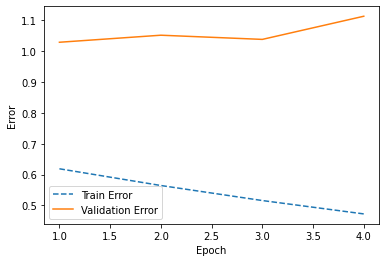

In [ ]:
# get the following plots of the training MSE loss for the different the 
# embedding and epoches sizes
plt.plot([1,2,3,4],history.history["loss"],label ='Train Error',linestyle="--")
plt.plot([1,2,3,4],history.history["val_loss"],label='Validation Error') 
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

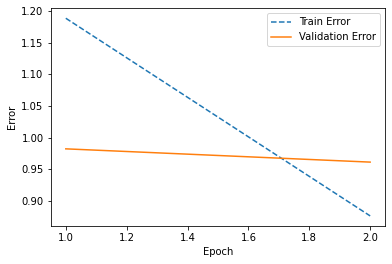

In [ ]:
# get the following plots of the training MSE loss for the different the 
# embedding and epoches sizes
plt.plot([1,2],history.history["loss"],label ='Train Error',linestyle="--")
plt.plot([1,2],history.history["val_loss"],label='Validation Error') 
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

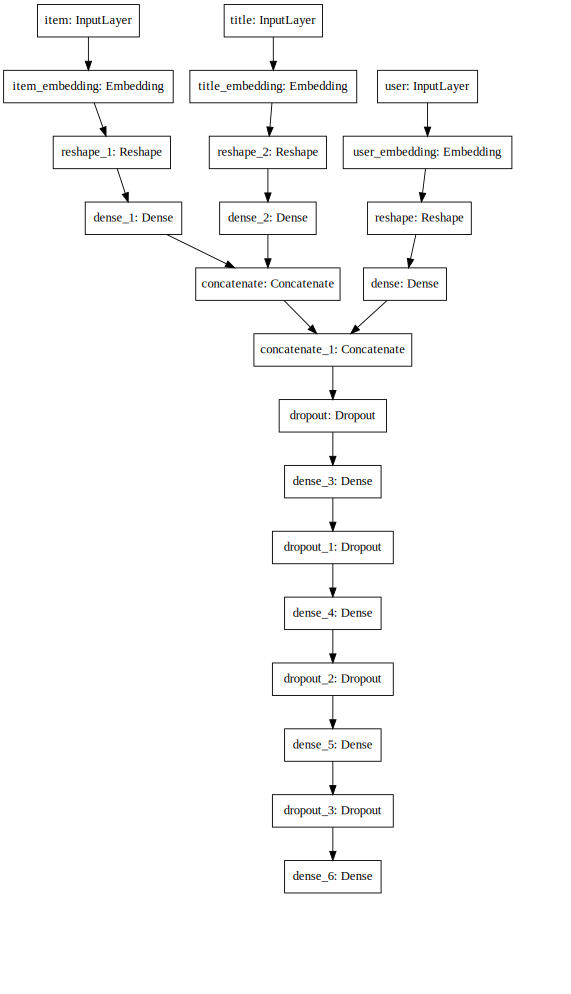

In [ ]:
# Display the model using keras
SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg'))

### Evaluate models

In [ ]:
# baseline: use average score as a results
data_test["avg_score"] = data_a["score"].mean()
mean_squared_error(data_test['score'], data_test['avg_score'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1.132207246122277

In [ ]:
pred_results = model.predict([data_test["user_id"],data_test["item_id"],data_test["title_id"]])
mean_squared_error(data_test['score'], pred_results)

0.9515402471037095

### Use user and item features only

In [ ]:
# declare input embeddings to the model
# user input
user_id_input = Input(shape=[1],name="user")
# item input
item_id_input = Input(shape=[1],name="item")

# define the size of embeddings as a parameter
user_embedding_size = 10 
item_embedding_size = 10  

# apply an embedding layer to all inputs
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users.shape[0],
                           input_length=1, name="user_embedding")(user_id_input)
item_embedding = Embedding(output_dim=item_embedding_size, 
                           input_dim=items.shape[0],
                           input_length=1, name="item_embedding")(item_id_input)

# reshape from shape (batch_size, input_length,embedding_size) to (batch_size, embedding_size)
user_vecs = Reshape([user_embedding_size])(user_embedding)
item_vecs = Reshape([item_embedding_size])(item_embedding)

# Applying matrix factorization: declare the output as being the dot product between the two embeddings: items and users
y = Dot(1, normalize=False)([user_vecs, item_vecs])

In [ ]:
# declare a model that takes items and users as input and output y, our prediction.
model = Model(inputs=[user_id_input, item_id_input],outputs=y)

In [ ]:
# compile the model with 'mse' loss, and "adam" loss optimization
model.compile(loss='mse',  optimizer="adam" )

In [ ]:
# Train the model by calling the model’s fit method
history = model.fit([data_train["user_id"], data_train["item_id"]],
                    data_train["score"],
                    batch_size=64,epochs=2,validation_split=0.2,
                    callbacks=[mcheck],shuffle=True)

Epoch 1/2
11432/11432 [==============================] - 249s 22ms/step - loss: 20.6728 - val_loss: 20.0195
Epoch 2/2
11432/11432 [==============================] - 206s 18ms/step - loss: 17.1666 - val_loss: 14.9912


In [ ]:
# Get the summary of model
# Matrix Factorization Model
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        1274750     user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        413200      item[0][0]                       
_______________________________________________________________________________________

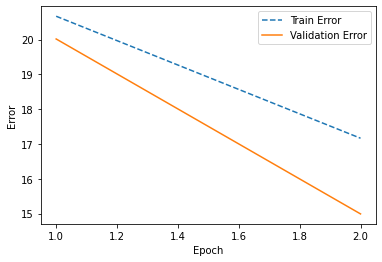

In [ ]:
# get the following plots of the training MSE loss for the different the 
# embedding and epoches sizes
plt.plot([1,2],history.history["loss"],label ='Train Error',linestyle="--")
plt.plot([1,2],history.history["val_loss"],label='Validation Error') 
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

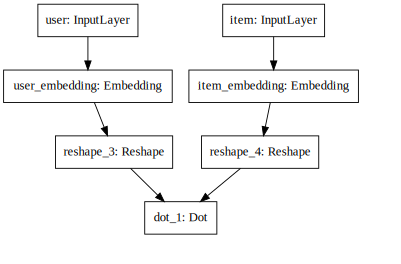

In [ ]:
# Display the model using keras
SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg'))

In [ ]:
# Evaluation Part
pred_results = model.predict([data_test["user_id"],data_test["item_id"],data_test["title_id"]])
mean_squared_error(data_test['score'], pred_results)

15.021347986523242

### Deep Neural Network 10 embeddings 3 layers with 2 features in 10 epochs

In [ ]:
# declare input embeddings to the model
# user input
user_id_input = Input(shape=[1],name="user")
# item input
item_id_input = Input(shape=[1],name="item")

# define the size of embeddings as a parameter
user_embedding_size = 10 
item_embedding_size = 10  

# apply an embedding layer to all inputs
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users.shape[0],
                           input_length=1, name="user_embedding")(user_id_input)
item_embedding = Embedding(output_dim=item_embedding_size, 
                           input_dim=items.shape[0],
                           input_length=1, name="item_embedding")(item_id_input)

# reshape from shape (batch_size, input_length,embedding_size) to (batch_size, embedding_size)
user_vecs = Reshape([user_embedding_size])(user_embedding)
item_vecs = Reshape([item_embedding_size])(item_embedding)

In [ ]:
# Multiply user and item embeddings and use them as features for the neural network
input_vecs = Multiply()([user_vecs, item_vecs]) # can be changed by concat

# Dropout is a technique where randomly selected neurons are ignored during training to prevent overfitting 
input_vecs = Dropout(0.1)(input_vecs)

# Check one dense 128 or two dense layers (128,128) or (128,64) or three denses layers (128,64,32))

# First layer
# Dense(128) is a fully-connected layer with 128 hidden units.
# Use rectified linear units (ReLU) f(x)=max(0,x) as an activation function.
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# Next Layers
#x = Dense(128, activation='relu')(x) # Add dense again or not
x = Dense(64, activation="relu")(x) # Add dense again or not
x = Dense(32, activation='relu')(x) # Add dense again or not #

# The output
y = Dense(1)(x)

In [ ]:
# declare a model that takes items and users as input and output y, our prediction.
model = Model(inputs=[user_id_input, item_id_input],outputs=y)

In [ ]:
# compile the model with 'mse' loss, and "adam" loss optimization
model.compile(loss='mse',  optimizer="adam" )

In [ ]:
# Train the model by calling the model’s fit method
history = model.fit([data_train["user_id"], data_train["item_id"]],
                    data_train["score"],
                    batch_size=64,epochs=10,validation_split=0.2,
                    callbacks=[mcheck],shuffle=True)

Epoch 1/10
11432/11432 [==============================] - 248s 22ms/step - loss: 1.1860 - val_loss: 1.0905
Epoch 2/10
11432/11432 [==============================] - 228s 20ms/step - loss: 0.7815 - val_loss: 1.1860
Epoch 3/10
11432/11432 [==============================] - 226s 20ms/step - loss: 0.4919 - val_loss: 1.3524
Epoch 4/10
11432/11432 [==============================] - 245s 21ms/step - loss: 0.3591 - val_loss: 1.4313
Epoch 5/10
11432/11432 [==============================] - 248s 22ms/step - loss: 0.2866 - val_loss: 1.4495
Epoch 6/10
11432/11432 [==============================] - 252s 22ms/step - loss: 0.2432 - val_loss: 1.4018
Epoch 7/10
11432/11432 [==============================] - 244s 21ms/step - loss: 0.2117 - val_loss: 1.3943
Epoch 8/10
11432/11432 [==============================] - 249s 22ms/step - loss: 0.1908 - val_loss: 1.3833
Epoch 9/10
11432/11432 [==============================] - 257s 22ms/step - loss: 0.1755 - val_loss: 1.3454
Epoch 10/10
11432/11432 [============

In [ ]:
# Get the summary of model
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        1274750     user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        413200      item[0][0]                       
_______________________________________________________________________________________

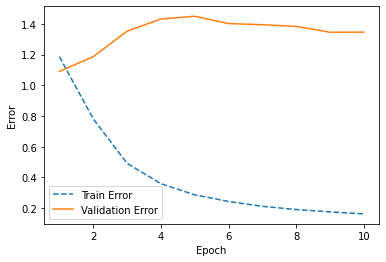

In [ ]:
# get the following plots of the training MSE loss for the different the 
# embedding and epoches sizes
plt.plot([1,2,3,4,5,6,7,8,9,10],history.history["loss"],label ='Train Error',linestyle="--")
plt.plot([1,2,3,4,5,6,7,8,9,10],history.history["val_loss"],label='Validation Error') 
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

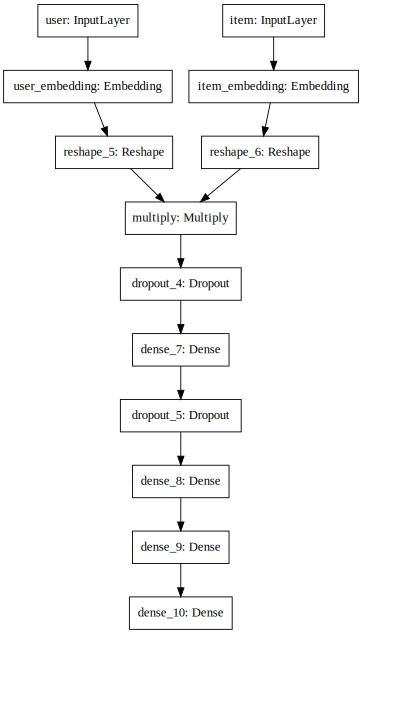

In [ ]:
# Display the model using keras
SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg'))

### Multiply with three features

In [ ]:
# declare input embeddings to the model
# user input
user_id_input = Input(shape=[1],name="user")
# item input
item_id_input = Input(shape=[1],name="item")
title_id_input = Input(shape=[1],name="title")

# define the size of embeddings as a parameter
user_embedding_size = 15 
item_embedding_size = 15 
title_embedding_size = 15 

# apply an embedding layer to all inputs
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users.shape[0],
                           input_length=1, name="user_embedding")(user_id_input)
item_embedding = Embedding(output_dim=item_embedding_size, 
                           input_dim=items.shape[0],
                           input_length=1, name="item_embedding")(item_id_input)
title_embedding = Embedding(output_dim=title_embedding_size, 
                           input_dim=titles.shape[0],
                           input_length=1, name="title_embedding")(title_id_input)

# reshape from shape (batch_size, input_length,embedding_size) to (batch_size, embedding_size)
user_vecs = Reshape([user_embedding_size])(user_embedding)
item_vecs = Reshape([item_embedding_size])(item_embedding)
title_vecs = Reshape([title_embedding_size])(title_embedding)

In [ ]:
# Instead of taking a dot product of the user and the item embedding, concatenate or multiply them 
# and use them as features for a neural network.

# Try add dense layers on top of the embeddings before merging (Comment to drop this idea.)
user_vecs = Dense(64, activation="relu")(user_vecs)
item_vecs = Dense(64, activation="relu")(item_vecs)
title_vecs = Dense(64, activation="relu")(title_vecs)

In [ ]:
# Concatenate the item embeddings
#item_vecs_complete  = Concatenate()([item_vecs,title_vecs])
item_vecs_complete  = Multiply()([item_vecs,title_vecs])

# Concatenate user and item embeddings and use them as features for the neural network
#input_vecs = Concatenate()([user_vecs, item_vecs_complete]) # can be changed by Multiply

# Multiply user and item embeddings and use them as features for the neural network
input_vecs = Multiply()([user_vecs, item_vecs_complete]) # can be changed by concat

# Dropout is a technique where randomly selected neurons are ignored during training to prevent overfitting 
input_vecs = Dropout(0.1)(input_vecs)

# Check one dense 128 or two dense layers (128,128) or (128,64) or three denses layers (128,64,32))

# First layer
# Dense(128) is a fully-connected layer with 128 hidden units.
# Use rectified linear units (ReLU) f(x)=max(0,x) as an activation function.
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# Next Layers
#x = Dense(128, activation='relu')(x) # Add dense again or not
x = Dense(64, activation="relu")(x) # Add dense again or not
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance
x = Dense(32, activation='relu')(x) # Add dense again or not #
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# The output
y = Dense(1)(x)

In [ ]:
# declare a model that takes items and users as input and output y, our prediction.
model = Model(inputs=[user_id_input, item_id_input, title_id_input],outputs=y)

In [ ]:
# compile the model with 'mse' loss, and "adam" loss optimization
model.compile(loss='mse',  optimizer="adam" )

In [ ]:
# Train the model by calling the model’s fit method
history = model.fit([data_train["user_id"], data_train["item_id"], 
                     data_train["title_id"]],data_train["score"],
                    batch_size=64,epochs=3,validation_split=0.2,
                    callbacks=[mcheck],shuffle=True)

Epoch 1/3
11432/11432 [==============================] - 421s 37ms/step - loss: 1.1945 - val_loss: 0.9811
Epoch 2/3
11432/11432 [==============================] - 413s 36ms/step - loss: 0.8319 - val_loss: 0.9610
Epoch 3/3
11432/11432 [==============================] - 412s 36ms/step - loss: 0.6610 - val_loss: 0.9931


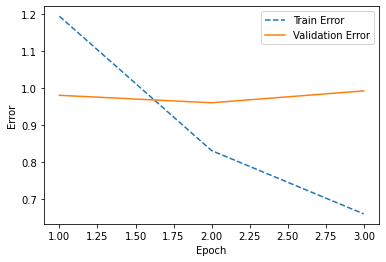

In [ ]:
# get the following plots of the training MSE loss for the different the 
# embedding and epoches sizes
plt.plot([1,2,3],history.history["loss"],label ='Train Error',linestyle="--")
plt.plot([1,2,3],history.history["val_loss"],label='Validation Error') 
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

### 3 layers, 50 embeddings, Multiply



In [ ]:
# declare input embeddings to the model
# user input
user_id_input = Input(shape=[1],name="user")
# item input
item_id_input = Input(shape=[1],name="item")
title_id_input = Input(shape=[1],name="title")

# define the size of embeddings as a parameter
user_embedding_size = 50 
item_embedding_size = 50 
title_embedding_size = 50 

# apply an embedding layer to all inputs
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users.shape[0],
                           input_length=1, name="user_embedding")(user_id_input)
item_embedding = Embedding(output_dim=item_embedding_size, 
                           input_dim=items.shape[0],
                           input_length=1, name="item_embedding")(item_id_input)
title_embedding = Embedding(output_dim=title_embedding_size, 
                           input_dim=titles.shape[0],
                           input_length=1, name="title_embedding")(title_id_input)

# reshape from shape (batch_size, input_length,embedding_size) to (batch_size, embedding_size)
user_vecs = Reshape([user_embedding_size])(user_embedding)
item_vecs = Reshape([item_embedding_size])(item_embedding)
title_vecs = Reshape([title_embedding_size])(title_embedding)

In [ ]:
# Instead of taking a dot product of the user and the item embedding, concatenate or multiply them 
# and use them as features for a neural network.

# Try add dense layers on top of the embeddings before merging (Comment to drop this idea.)
user_vecs = Dense(64, activation="relu")(user_vecs)
item_vecs = Dense(64, activation="relu")(item_vecs)
title_vecs = Dense(64, activation="relu")(title_vecs)

In [ ]:
# Concatenate the item embeddings
#item_vecs_complete  = Concatenate()([item_vecs,title_vecs])
item_vecs_complete  = Multiply()([item_vecs,title_vecs])

# Concatenate user and item embeddings and use them as features for the neural network
#input_vecs = Concatenate()([user_vecs, item_vecs_complete]) # can be changed by Multiply

# Multiply user and item embeddings and use them as features for the neural network
input_vecs = Multiply()([user_vecs, item_vecs_complete]) # can be changed by concat

# Dropout is a technique where randomly selected neurons are ignored during training to prevent overfitting 
input_vecs = Dropout(0.1)(input_vecs)

# Check one dense 128 or two dense layers (128,128) or (128,64) or three denses layers (128,64,32))

# First layer
# Dense(128) is a fully-connected layer with 128 hidden units.
# Use rectified linear units (ReLU) f(x)=max(0,x) as an activation function.
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# Next Layers
#x = Dense(128, activation='relu')(x) # Add dense again or not
x = Dense(64, activation="relu")(x) # Add dense again or not
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance
x = Dense(32, activation='relu')(x) # Add dense again or not #
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# The output
y = Dense(1)(x)

In [ ]:
# declare a model that takes items and users as input and output y, our prediction.
model = Model(inputs=[user_id_input, item_id_input, title_id_input],outputs=y)

In [ ]:
# compile the model with 'mse' loss, and "adam" loss optimization
model.compile(loss='mse',  optimizer="adam" )

In [ ]:
# Train the model by calling the model’s fit method
history = model.fit([data_train["user_id"], data_train["item_id"], 
                     data_train["title_id"]],data_train["score"],
                    batch_size=64,epochs=3,validation_split=0.2,
                    callbacks=[mcheck],shuffle=True)

Epoch 1/3
11432/11432 [==============================] - 1206s 105ms/step - loss: 1.2974 - val_loss: 1.0736
Epoch 2/3
11432/11432 [==============================] - 1193s 104ms/step - loss: 0.6043 - val_loss: 1.2313
Epoch 3/3
11432/11432 [==============================] - 1191s 104ms/step - loss: 0.3274 - val_loss: 1.2119


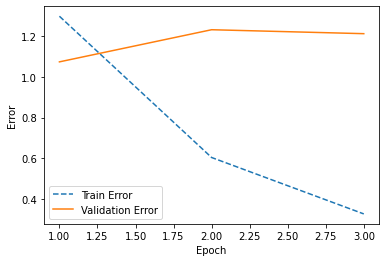

In [ ]:
# get the following plots of the training MSE loss for the different the 
# embedding and epoches sizes
plt.plot([1,2,3],history.history["loss"],label ='Train Error',linestyle="--")
plt.plot([1,2,3],history.history["val_loss"],label='Validation Error') 
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

In [ ]:
### Best Model Training

In [ ]:
# declare input embeddings to the model
# user input
user_id_input = Input(shape=[1],name="user")
# item input
item_id_input = Input(shape=[1],name="item")
title_id_input = Input(shape=[1],name="title")

# define the size of embeddings as a parameter
user_embedding_size = 15 
item_embedding_size = 15 
title_embedding_size = 15 

# apply an embedding layer to all inputs
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users.shape[0],
                           input_length=1, name="user_embedding")(user_id_input)
item_embedding = Embedding(output_dim=item_embedding_size, 
                           input_dim=items.shape[0],
                           input_length=1, name="item_embedding")(item_id_input)
title_embedding = Embedding(output_dim=title_embedding_size, 
                           input_dim=titles.shape[0],
                           input_length=1, name="title_embedding")(title_id_input)

# reshape from shape (batch_size, input_length,embedding_size) to (batch_size, embedding_size)
user_vecs = Reshape([user_embedding_size])(user_embedding)
item_vecs = Reshape([item_embedding_size])(item_embedding)
title_vecs = Reshape([title_embedding_size])(title_embedding)

In [ ]:
# Instead of taking a dot product of the user and the item embedding, concatenate or multiply them 
# and use them as features for a neural network.

# Try add dense layers on top of the embeddings before merging (Comment to drop this idea.)
user_vecs = Dense(64, activation="relu")(user_vecs)
item_vecs = Dense(64, activation="relu")(item_vecs)
title_vecs = Dense(64, activation="relu")(title_vecs)

In [ ]:
# Concatenate the item embeddings
#item_vecs_complete  = Concatenate()([item_vecs,title_vecs])
item_vecs_complete  = Multiply()([item_vecs,title_vecs])

# Concatenate user and item embeddings and use them as features for the neural network
#input_vecs = Concatenate()([user_vecs, item_vecs_complete]) # can be changed by Multiply

# Multiply user and item embeddings and use them as features for the neural network
input_vecs = Multiply()([user_vecs, item_vecs_complete]) # can be changed by concat

# Dropout is a technique where randomly selected neurons are ignored during training to prevent overfitting 
input_vecs = Dropout(0.1)(input_vecs)

# Check one dense 128 or two dense layers (128,128) or (128,64) or three denses layers (128,64,32))

# First layer
# Dense(128) is a fully-connected layer with 128 hidden units.
# Use rectified linear units (ReLU) f(x)=max(0,x) as an activation function.
x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# Next Layers
#x = Dense(128, activation='relu')(x) # Add dense again or not
x = Dense(64, activation="relu")(x) # Add dense again or not
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance
x = Dense(32, activation='relu')(x) # Add dense again or not #
x = Dropout(0.1)(x) # Add droupout or not # To improve the performance

# The output
y = Dense(1)(x)

In [ ]:
# declare a model that takes items and users as input and output y, our prediction.
model = Model(inputs=[user_id_input, item_id_input, title_id_input],outputs=y)

In [ ]:
# compile the model with 'mse' loss, and "adam" loss optimization
model.compile(loss='mse',  optimizer="adam" )

In [ ]:
# Train the model by calling the model’s fit method
history = model.fit([data_train["user_id"], data_train["item_id"], 
                     data_train["title_id"]],data_train["score"],
                    batch_size=64,epochs=2,validation_split=0.2,
                    callbacks=[mcheck],shuffle=True)

Epoch 1/2
11432/11432 [==============================] - 375s 33ms/step - loss: 1.2148 - val_loss: 0.9760
Epoch 2/2
11432/11432 [==============================] - 372s 33ms/step - loss: 0.8427 - val_loss: 0.9593


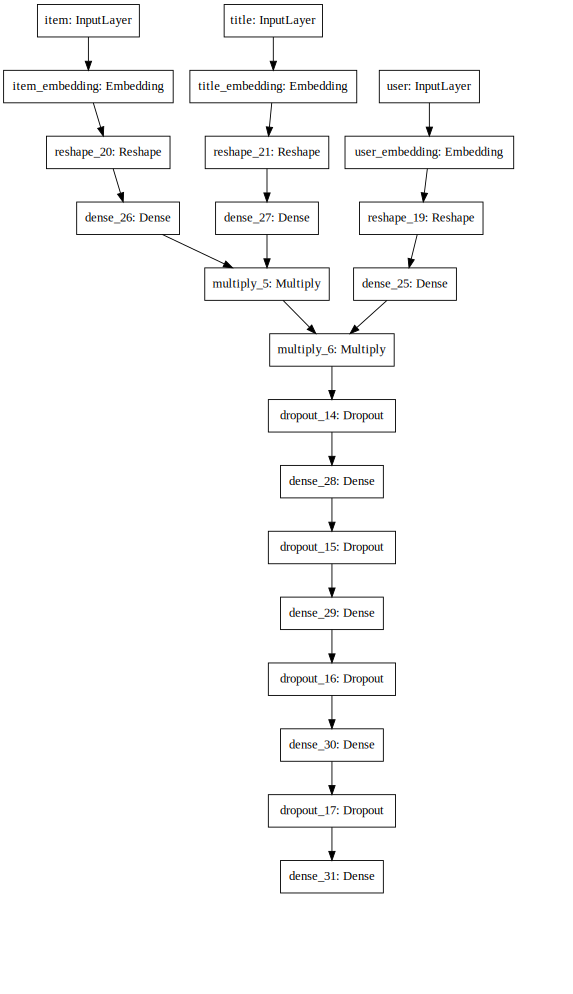

In [ ]:
# Display the model using keras
SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg'))

In [ ]:
# Evaluation
pred_results = model.predict([data_test["user_id"],data_test["item_id"],data_test["title_id"]])
mean_squared_error(data_test['score'], pred_results)

0.949706197805106

In [ ]:
# baseline: use average score as a results
data_test["avg_score"] = data_a["score"].mean()
mean_squared_error(data_test['score'], data_test['avg_score'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1.132207246122277

### Recommend


For the requested user:

1. Calculate the score for every item.
2. Sort the items based on the score and output the top results.


In [ ]:
# Check which users exist on the test set
data_test.user_id.value_counts().sort_values(ascending=False).head(10)

842      127
355       87
17979     85
2807      77
424       71
2023      69
1839      60
888       60
927       57
4973      54
Name: user_id, dtype: int64

In [ ]:
# Create a recommendation example dataset of 100 users from the test set and 100 random items for each and predict recommendations for them
items = data_a.item_id.unique()
df_items = pd.DataFrame(data=items,columns=['item_id'])
df_items = pd.merge(df_items,data_a,how='left',left_on='item_id',right_on='item_id')
df_items= df_items.sample(100)
df_items['key'] = 1
print ("We have %d unique items  "%df_items['item_id'].shape[0])
df_items= df_items[['item_id', 'title', 'key',"title_id"]]
df_items.head(2)

We have 100 unique items  


,item_id,title,key,title_id
1058467,34978,Starbucks Frappuccino Variety Pack (15 Pack),1,34668
1077243,35986,"Smartfruit Harvest Greens, 100% Real Fruit Smo...",1,35673


In [ ]:
users = data_test.user_id.unique()
df_users = pd.DataFrame(data=users,columns=['user_id'])
df_users = pd.merge(df_users,data_test,how='left',left_on='user_id',right_on='user_id')
df_users= df_users.sample(100)
df_users['key'] = 1
print ("We have %d unique users  "%df_users['user_id'].shape[0])
df_users= df_users[['user_id', 'user_name', 'key']]
df_users.head(2)

We have 100 unique users  


,user_id,user_name,key
74421,37608,Sherry S.,1
29694,81956,Teresa1106,1


In [ ]:
# Merge item and user data to get our own database
df_unseenData= pd.merge(df_users, df_items, on='key')
del df_unseenData['key']
print ("We have %d unique records in the recommendation example dataset "%df_unseenData.shape[0])
df_unseenData.head(2)

We have 10000 unique records in the recommendation example dataset 


,user_id,user_name,item_id,title,title_id
0,37608,Sherry S.,34978,Starbucks Frappuccino Variety Pack (15 Pack),34668
1,37608,Sherry S.,35986,"Smartfruit Harvest Greens, 100% Real Fruit Smo...",35673


In [ ]:
df_unseenData["predict_score"] = model.predict([df_unseenData["user_id"],df_unseenData["item_id"],df_unseenData["title_id"]])

In [ ]:
df_unseenData.user_id.unique()

array([ 37608,  81956,  11807, 122094,  84519,  52378,  34384,  44933,
        82024,  25362,  61554, 122289,  68245, 116108, 106098,  42400,
        26251,  76270,  63483,  39908,  24757,  89215,  82426,  15650,
        68628,  44869,  63555,   5549,  70581,  14938, 102494,  75546,
        31299,  41327,  90059,  94677,  49264, 120803,  92929,  16715,
        53594, 102854,   4746, 125419, 114474,  36902,  49145,  58306,
        18502,   9268,   6761,  59044,  11867,  93217, 101421,  92236,
        20598,   3475,  39686,  93546, 102241,  21577,  75929, 119440,
         1067,   1290, 109481, 121958,   6472,  17669, 122957,  27819,
       126749, 115824,  53303,  38403,  53138,  67735,  62499,  59539,
        25301,  48189, 125369,   9438,   7009,  19890,  89356,  24416,
         2417, 106460,  81861,  38321,  91102,  51123,   4825,  92217,
       118805, 103503, 107436,  59499])

In [ ]:
def get_recommendations(userID , df_Data):
    if userID not in df_Data['user_id'].values:
        print("\nUser ID not found %d" %userID)
        return userID
       
    print("\nRecommendations for user id %d Name: %s is:" % (userID, df_Data.loc[df_Data['user_id'] == userID, 'user_name'].values[0]))
   
    df_output=df_Data.loc[df_Data['user_id'] == userID][['item_id','title','predict_score',    
     ]].sort_values('predict_score',ascending=False).set_index('item_id')
    
    df_output.rename(columns={'predict_score': 'score'}, inplace=True)
    return df_output

In [ ]:
# select 45302
df_output = get_recommendations(userID=37608,df_Data=df_unseenData)
df_output.head(10)


Recommendations for user id 37608 Name: Sherry S. is:


,title,score
item_id,,
5632,Bionutritional Power Crunch Bars Peanut Butter...,4.914780
2250,"Power Crunch High Protein Energy Snack, Cookie...",4.913166
32045,"KIND Bars, Caramel Almond and Sea Salt, Gluten...",4.908445
22207,"KIND Bars, Dark Chocolate Nuts &amp; Sea Salt,...",4.902559
22207,"KIND Bars, Dark Chocolate Nuts &amp; Sea Salt,...",4.902559
24555,"Kind Bars, Madagascar Vanilla Almond, Gluten F...",4.893414
15363,"Kettle Brand Potato Chips, Jalapeno, Single-Se...",4.867397
32565,"KIND Bars, Cranberry Almond + Antioxidants wit...",4.832794
2878,REESE'S Pieces Peanut Butter Candy (Pack of 18),4.752003


In [ ]:
# Check what movies user gives high scores
data_a.head()

,asin,summary,reviewText,score,user_id,user_name,reviewTime,old_item_id,item_id,old_user_id,title,title_id
0,4639725183,Five Stars,No adverse comment.,5,0,Jamshed Mathur,"11 19, 2014",4639725183,0,A1QVBUH9E1V6I8,Lipton Yellow Label Finest Blend Tea Bags 100 ...,0
1,4639725183,Great product.,Gift for college student.,5,1,itsjustme,"10 13, 2016",4639725183,0,A3GEOILWLK86XM,Lipton Yellow Label Finest Blend Tea Bags 100 ...,0
2,4639725183,Strong,"If you like strong tea, this is for you. It mi...",5,2,Krystal Clifton,"11 21, 2015",4639725183,0,A32RD6L701BIGP,Lipton Yellow Label Finest Blend Tea Bags 100 ...,0
3,4639725183,Great tea,Love the tea. The flavor is way better than th...,5,3,U. Kane,"08 12, 2015",4639725183,0,A2UY1O1FBGKIE6,Lipton Yellow Label Finest Blend Tea Bags 100 ...,0
4,4639725183,This is the tea I remembered!,I have searched everywhere until I browsed Ama...,5,4,The Nana,"05 28, 2015",4639725183,0,A3QHVBQYDV7Z6U,Lipton Yellow Label Finest Blend Tea Bags 100 ...,0


In [ ]:
table = data_a[data_a["user_id"]==45302]

In [ ]:
table.shape

(12, 12)

In [ ]:
table.head()

,asin,summary,reviewText,score,user_id,user_name,reviewTime,old_item_id,item_id,old_user_id,title,title_id
71097,B000ELQNRE,Love this flavor,"I'm not much of an English toffee person, so I...",5,45302,Katelyn,"09 15, 2015",B000ELQNRE,1618,A3F5N5TZDK6BEO,"SweetLeaf Sweet Drops Liquid Stevia Sweetener,...",1618
443672,B004391DK0,This one certainly tastes the best. There is a...,I have tried a couple different kinds of glute...,5,45302,Katelyn,"05 17, 2016",B004391DK0,12489,A3F5N5TZDK6BEO,"Betty Crocker Bisquick Baking Mix, Gluten Free...",12286
448060,B0045IO2VQ,"Teste good, could be stronger","Taste really good, one of the better ones I ha...",4,45302,Katelyn,"12 19, 2014",B0045IO2VQ,12640,A3F5N5TZDK6BEO,Cafe Escapes Cafe&sbquo; Mocha - 16 ct,12437
492016,B004X71550,"Good taste, don't like the carbs",I have been a stevia user for a few years beca...,4,45302,Katelyn,"12 15, 2016",B004X71550,14582,A3F5N5TZDK6BEO,Swerve Granular Sweetener 12 Ounce + Measuring...,14372
533111,B005K4Q1YA,Good price,These taste great. I love the Grove Square bra...,5,45302,Katelyn,"06 14, 2017",B005K4Q1YA,16191,A3F5N5TZDK6BEO,"Grove Square Cappuccino, French Vanilla, 24 Co...",15974


In [ ]:
table.score.min()

4

In [ ]:
for i in list(table[table["score"]==5].title):
  print(i)

SweetLeaf Sweet Drops Liquid Stevia Sweetener, English Toffee, 2 Ounce
Betty Crocker Bisquick Baking Mix, Gluten Free Pancake and Baking Mix, 16 Oz Box (Pack of 3)
Grove Square Cappuccino, French Vanilla, 24 Count Single Serve Cups
Grove Square CARAMEL HOT APPLE CIDER - 12 Single serve cups
Grove Square SPICED HOT APPLE CIDER - 12 cups
Barilla Gluten Free Pasta, Elbows, 12 Ounce (Pack of 12)
SweetLeaf Sweet Drops Liquid Stevia Sweetener, Chocolate, 2 Ounce
30-count Top Brand Coffee, Tea, Cider, Hot Cocoa and Cappuccino Variety Sampler Pack, Single-Serve Cups for Keurig-Compatible Brewers


In [ ]:
result = list(df_output.head(10).title)
for i in result:
  print(i)

Bionutritional Power Crunch Bars Peanut Butter Creme,  1.4 oz., 12 Bars
Power Crunch High Protein Energy Snack, Cookies &amp; Creme, 1.4-Ounce Bars (Pack of 12)
KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count
KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count
KIND Bars, Dark Chocolate Nuts &amp; Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count
Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz
Kettle Brand Potato Chips, Jalapeno, Single-Serve 1 Ounce Bags (Pack of 72)
KIND Bars, Cranberry Almond + Antioxidants with Macadamia Nuts, Gluten Free, Low Sugar, 1.4oz, 12 Count
REESE'S Pieces Peanut Butter Candy (Pack of 18)
Viva Naturals #1 Best Selling Certified Organic Cacao Powder from Superior Criollo Beans, 1 LB Bag
